# Power analysis and comparison

We now see how well the method is able to recognize a scenario of two different groups, and how well the method can recover the original order of students, in comparison to the 1-parameter logistic method from item response theory.

## Imports

In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [2]:
from pl import p as pl_p, dpds as pl_dpds, dpdq as pl_dpdq

In [3]:
from functools import partial

In [4]:
from multiprocessing import Pool

## Problem size

The larger the problem, the smaller the difference between the methods for a fixed difference between the groups, it seems like.

In [5]:
S = 50
Q = 25

## Technical

How often to simulate, and how often to recompute the same solution for numerical stability and result quality.

In [6]:
n = 1000
nr_evals = 10

Utility functions

In [7]:
pack = lambda s, q: np.concatenate((np.reshape(s, S), np.reshape(q, Q)))
unpack = lambda x: (np.reshape(x[:S], S), np.reshape(x[S:], Q))

## Data generation

A first scenario: equidistant student and question values. This is used to test order recovery.

In [8]:
s = np.linspace(0, 1, S + 1, endpoint=False)[1:]
q = np.linspace(0, 1, Q + 1, endpoint=False)[1:]

In [9]:
from pde import p as pde_p

In [10]:
p = pde_p(s.transpose(), q)
p.shape

(50, 25)

We again want to filter constant rows and columns.

In [11]:
def has_constant_row_or_column(A):
    return np.logical_or(
        np.any(np.logical_or(np.all(A, axis=0), np.all(1 - A, axis=0))),
        np.any(np.logical_or(np.all(A, axis=1), np.all(1 - A, axis=1))),
    )

In [12]:
def generate_matrices(p, n):
    As = list()
    while len(As) != n:
        A = np.random.binomial(1, p)
        if not has_constant_row_or_column(A):
            As.append(A)
    return As

In [13]:
As = generate_matrices(p, n)

## Setting up the solving method

In [14]:
from pde import p as pde_p, dpds as pde_dpds, dpdq as pde_dpdq

In [15]:
from mle import neg_log_likelihood, d_neg_log_likelihood

In [16]:
bounds = [(0, 1)] * (S + Q)

In [17]:
def best_nll_solution(A, p, dpds, dpdq):
    best_nll = min(
        (minimize(
            partial(neg_log_likelihood, 
                    p=p, A=A, S=S),
            np.random.rand(S + Q),
            jac=partial(d_neg_log_likelihood,
                        p=p, dpds=dpds, dpdq=dpdq, A=A, S=S),
            bounds=bounds,
        ) for _ in range(nr_evals)),
        key=lambda result: result.fun,
    )
    return best_nll

### Assessment of how stable the solver is

In [18]:
def calc(_):
    return minimize(
        partial(neg_log_likelihood, 
                p=pde_p, A=As[0], S=S),
        np.random.rand(S + Q),
        jac=partial(d_neg_log_likelihood,
                    p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq, A=As[0], S=S),
        bounds=bounds,
    )

with Pool(7) as pool:
    result = pool.map(calc, range(500))

In [19]:
np.mean([mle.success for mle in result])

0.262

In [20]:
lowest = min(mle.fun for mle in result)
np.mean([mle.fun < lowest * 1.01 for mle in result])

0.538

(array([13.,  0.,  0.,  0., 14.,  0., 21.,  0.,  7.,  6.,  0., 14.,  7.,
        21.,  0.,  0., 14., 14.,  7.,  7., 14.,  6.,  6.,  7.,  7., 21.,
         0., 14., 14., 35.]),
 array([0.42059816, 0.42073522, 0.42087227, 0.42100933, 0.42114639,
        0.42128345, 0.4214205 , 0.42155756, 0.42169462, 0.42183168,
        0.42196873, 0.42210579, 0.42224285, 0.4223799 , 0.42251696,
        0.42265402, 0.42279108, 0.42292813, 0.42306519, 0.42320225,
        0.42333931, 0.42347636, 0.42361342, 0.42375048, 0.42388754,
        0.42402459, 0.42416165, 0.42429871, 0.42443577, 0.42457282,
        0.42470988]),
 <a list of 30 Patch objects>)

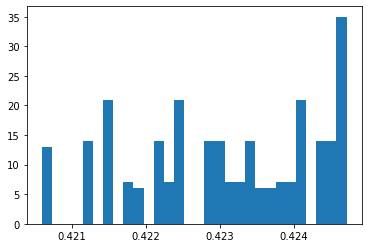

In [21]:
plt.hist(
    [mle.fun for mle in result if mle.fun < lowest * 1.01],
    bins=30,
)

Approximate number of evaluations needed to achieve a certain precision with a certain probability. Can be set at the start of this script. Note that this estimate depends on the specific matrix being solved during this test.

In [22]:
from math import log as mlog, ceil as mceil
mceil(mlog(
    .01, 
    1 - np.mean([mle.fun < lowest * (1 + .01) for mle in result]),
))

6

This number can be seen fluctuating heavily between matrices for the current instance sizes.

## Solving with the new method

In [23]:
with Pool(7) as pool:
    mles = pool.map(
        partial(
            best_nll_solution,
            p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq,
        ),
        As,
    )

## Behavior of the likelihood

Approximate distribution of the likelihood of the maximum likelihood estimator.

(array([  5.,   2.,  11.,  17.,  27.,  53.,  94., 126., 116., 139., 124.,
        106.,  82.,  48.,  27.,  11.,   7.,   3.,   0.,   2.]),
 array([-0.48052441, -0.47570342, -0.47088243, -0.46606144, -0.46124045,
        -0.45641945, -0.45159846, -0.44677747, -0.44195648, -0.43713548,
        -0.43231449, -0.4274935 , -0.42267251, -0.41785152, -0.41303052,
        -0.40820953, -0.40338854, -0.39856755, -0.39374655, -0.38892556,
        -0.38410457]),
 <a list of 20 Patch objects>)

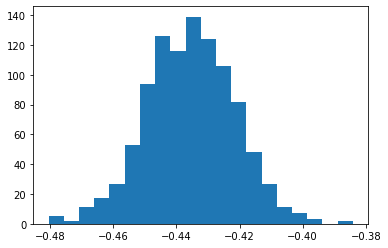

In [24]:
plt.hist([-mle.fun for mle in mles], bins=20)

In [25]:
true_lls = [-neg_log_likelihood(pack(s, q), pde_p, A, S) for A in As]

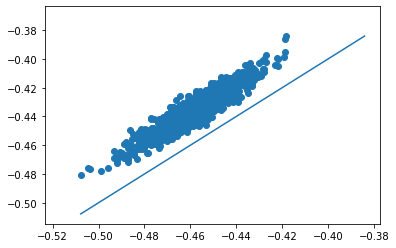

In [26]:
plt.scatter(true_lls, [-mle.fun for mle in mles])
all_lls = true_lls + [-mle.fun for mle in mles]
plt.plot([min(all_lls), max(all_lls)], [min(all_lls), max(all_lls)])

In [27]:
diff = [2 * (mle.fun - true) for mle, true in zip(mles, true_lls)]

(array([  2.,   2.,   7.,  10.,  27.,  38.,  78., 106., 130., 130., 133.,
        111.,  89.,  65.,  32.,  17.,  14.,   4.,   2.,   3.]),
 array([1.60443772, 1.62304298, 1.64164825, 1.66025352, 1.67885878,
        1.69746405, 1.71606932, 1.73467458, 1.75327985, 1.77188512,
        1.79049038, 1.80909565, 1.82770092, 1.84630618, 1.86491145,
        1.88351672, 1.90212198, 1.92072725, 1.93933252, 1.95793778,
        1.97654305]),
 <a list of 20 Patch objects>)

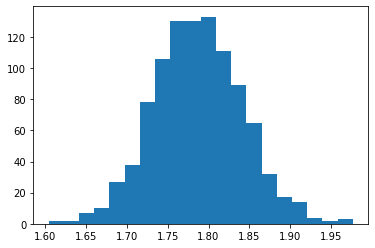

In [28]:
plt.hist(diff, bins=20)

This is not an M-estimator. The asymptotic distribution looks normal rather than chi-squared.

# Order recovery

We test approximate recovery of the order of the students.

In [29]:
def is_sorted(x):
    return np.all(np.diff(x) > 0)

In [30]:
def is_almost_sorted(x, swaps_allowed=1):
    return np.sum(np.diff(x) <= 0) <= swaps_allowed

In [31]:
nr_misordered = 25

### New method

(array([  1.,   7.,   0.,  12.,  32.,   0.,  85., 135.,   0., 195., 184.,
          0., 168., 103.,   0.,  49.,  23.,   0.,   3.,   3.]),
 array([21.  , 21.65, 22.3 , 22.95, 23.6 , 24.25, 24.9 , 25.55, 26.2 ,
        26.85, 27.5 , 28.15, 28.8 , 29.45, 30.1 , 30.75, 31.4 , 32.05,
        32.7 , 33.35, 34.  ]),
 <a list of 20 Patch objects>)

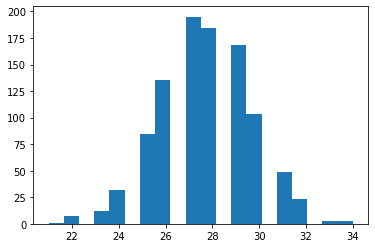

In [32]:
plt.hist([np.sum(np.diff(unpack(mle.x)[0]) > 0) for mle in mles], bins=20)

In [33]:
new_fraction_recovered = np.mean([is_almost_sorted(unpack(mle.x)[0], nr_misordered) for mle in mles])

### 1-PL

In [34]:
def pl_nll(A):
    return minimize(
        partial(neg_log_likelihood,
                p=pl_p, A=A, S=S),
        np.random.rand(S + Q),
        jac=partial(d_neg_log_likelihood,
                    p=pl_p, dpds=pl_dpds, dpdq=pl_dpdq, A=A, S=S),
    )

In [35]:
with Pool(7) as pool:
    PL_order_rec = pool.map(pl_nll, As)

(array([  4.,  12.,  32.,   0.,  71., 134.,   0., 165., 184.,   0., 192.,
        116.,  49.,   0.,  27.,   7.,   0.,   6.,   0.,   1.]),
 array([22. , 22.7, 23.4, 24.1, 24.8, 25.5, 26.2, 26.9, 27.6, 28.3, 29. ,
        29.7, 30.4, 31.1, 31.8, 32.5, 33.2, 33.9, 34.6, 35.3, 36. ]),
 <a list of 20 Patch objects>)

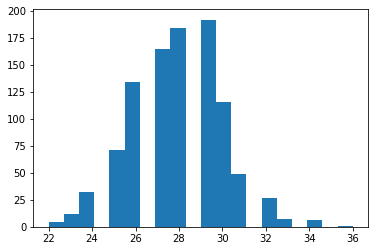

In [36]:
plt.hist([np.sum(np.diff(unpack(mle.x)[0]) > 0) for mle in PL_order_rec], bins=20)

In [37]:
existing_fraction_recovered = np.mean([is_almost_sorted(unpack(mle.x)[0], nr_misordered) for mle in PL_order_rec])

In [38]:
new_fraction_recovered, existing_fraction_recovered

(0.98, 0.984)

For a problem of this size, the method have similar order recovery performance.

## Power

In [39]:
assert S % 2 == 0 # We'll need to split into two groups

In [40]:
from scipy.stats import ranksums

In [41]:
def calculate_statistic(opt):
    s, _ = unpack(opt.x)
    stat = ranksums(s[:int(S / 2)], s[int(S / 2):S])
    return stat

### Under Null Hypothesis

In [42]:
s_null = np.full(S, .5)
p_null = pde_p(s_null.transpose(), q)

In [43]:
A_nulls = generate_matrices(p_null, n)

#### New method

In [44]:
with Pool(7) as pool:
    null_opts = pool.map(
        partial(
            best_nll_solution,
            p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq,
        ),
        A_nulls,
    )

In [45]:
null_stats = np.array([calculate_statistic(opt).statistic for opt in null_opts])

#### Existing method

In [46]:
with Pool(7) as pool:
    PL_null_opts = pool.map(pl_nll, A_nulls)

In [47]:
PL_null_stats = np.array([calculate_statistic(opt).statistic for opt in PL_null_opts])

### Result

(array([  8.,  38.,  90., 164., 220., 219., 145.,  81.,  29.,   6.]),
 array([-2.86192038, -2.27595431, -1.68998824, -1.10402217, -0.5180561 ,
         0.06790998,  0.65387605,  1.23984212,  1.82580819,  2.41177426,
         2.99774033]),
 <a list of 10 Patch objects>)

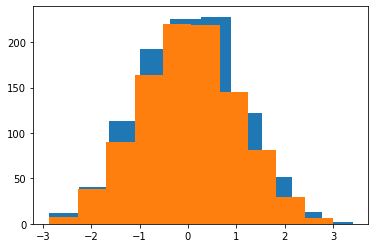

In [48]:
plt.hist(null_stats)
plt.hist(PL_null_stats)

### Under alternative

In [49]:
difference = .05
s_alt = np.concatenate((np.full(int(S / 2), .5 - difference), np.full(int(S / 2), .5 + difference)))
p_alt = pde_p(s_alt.transpose(), q)

In [50]:
A_alts = generate_matrices(p_alt, n)

In [51]:
alpha = .05

#### New method

In [52]:
with Pool(7) as pool:
    alt_opts = pool.map(
        partial(
            best_nll_solution,
            p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq,
        ),
        A_alts,
    )

In [53]:
alt_stats = np.array([calculate_statistic(opt).statistic for opt in alt_opts])

In [54]:
lower, upper = np.quantile(null_stats, (alpha / 2, 1 - alpha / 2))

(array([ 11.,  35.,  90., 184., 230., 235., 131.,  60.,  17.,   7.]),
 array([-4.72459398, -4.16191133, -3.59922868, -3.03654603, -2.47386338,
        -1.91118073, -1.34849808, -0.78581543, -0.22313278,  0.33954988,
         0.90223253]),
 <a list of 10 Patch objects>)

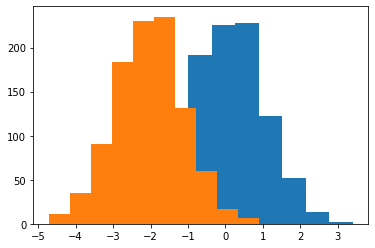

In [55]:
plt.hist(null_stats)
plt.hist(alt_stats)

In [56]:
new_power = np.mean(np.logical_or(alt_stats < lower, alt_stats > upper))

#### Existing method

In [57]:
with Pool(7) as pool:
    PL_alt_opts = pool.map(pl_nll, A_alts)

In [58]:
PL_alt_stats = np.array([calculate_statistic(opt).statistic for opt in PL_alt_opts])

In [59]:
PL_lower, PL_upper = np.quantile(PL_null_stats, (alpha / 2, 1 - alpha / 2))

(array([  8.,  34.,  81., 191., 228., 223., 152.,  61.,  17.,   5.]),
 array([-4.99623388, -4.4238498 , -3.85146573, -3.27908165, -2.70669758,
        -2.1343135 , -1.56192943, -0.98954535, -0.41716128,  0.1552228 ,
         0.72760688]),
 <a list of 10 Patch objects>)

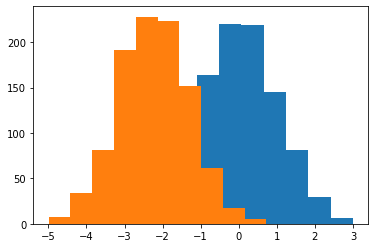

In [60]:
plt.hist(PL_null_stats)
plt.hist(PL_alt_stats)

In [61]:
existing_power = np.mean(np.logical_or(PL_alt_stats < PL_lower, PL_alt_stats > PL_upper))

#### Result

(array([  8.,  34.,  81., 191., 228., 223., 152.,  61.,  17.,   5.]),
 array([-4.99623388, -4.4238498 , -3.85146573, -3.27908165, -2.70669758,
        -2.1343135 , -1.56192943, -0.98954535, -0.41716128,  0.1552228 ,
         0.72760688]),
 <a list of 10 Patch objects>)

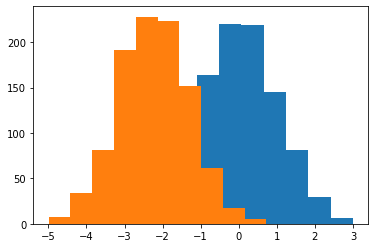

In [62]:
plt.hist(PL_null_stats)
plt.hist(PL_alt_stats)

In [63]:
new_power, existing_power

(0.55, 0.635)

We conclude that the existing method has more power in this scenario.

# Comparing 1-PL vs new

In [64]:
theta, b = unpack(PL_order_rec[0].x)
s2, q2 = unpack(mles[0].x)

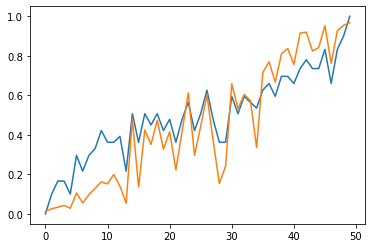

In [65]:
plt.plot((theta - theta.min()) / (theta - theta.min()).max())
plt.plot(s2)

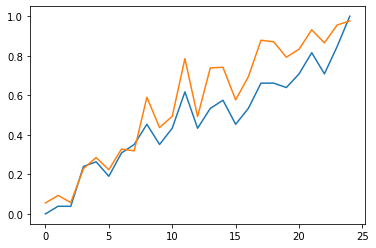

In [66]:
plt.plot(1 - (b - b.min()) / (b - b.min()).max())
plt.plot(q2)